In [1]:
import sys
sys.path.append('../')
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import momepy
import pandana

from src.get_ODmatrix import connect_poi

FUA:  -f 


ERROR


# Computing Isochron Statistics

Defining input directories:

In [2]:
talia_scratch_dir = '/scratch/kaufmann.t/Processed_data/'
gabriel_scratch_dir = '/scratch/g.spessatoagostini/'
fua_buffered_shapefile_dir = '../data/d03_intermediate/FUA-buffered-shapefile/'
full_od_matrix_dir = '../data/d02_processed-safegraph/'
networks_dir = '../data/d03_intermediate/FUA-networks/'

Getting the full CBG data:

In [3]:
full_cbg_stats = pd.read_csv(talia_scratch_dir+'cbg_links_stats.csv')

In [4]:
full_cbg_stats

,fuaname,pop_2018,census_block_group,top_category,no_poi,est_visitors,median_dist,min_dist,max_dist,cbg_pop,median_income,pop_below_poverty,percent_poor,income_level,poverty_level
0,Ada,757685,160010001001,Elementary and Secondary Schools,5,637.855585,633.83,514.682388,12025.504584,1273,28457.0,539,0.423409,$25K-$60K,poor
1,Ada,757685,160010001001,Grocery Stores,10,1514.351865,1963.78,674.062059,35973.531567,1273,28457.0,539,0.423409,$25K-$60K,poor
2,Ada,757685,160010001001,Health and Personal Care Stores,4,504.891407,2291.28,828.155926,8432.263049,1273,28457.0,539,0.423409,$25K-$60K,poor
3,Ada,757685,160010001001,"Museums, Historical Sites, and Similar Institu...",12,1481.242086,1648.42,368.118363,9423.414861,1273,28457.0,539,0.423409,$25K-$60K,poor
4,Ada,757685,160010001001,Other Amusement and Recreation Industries,15,1604.268122,6013.70,314.064388,27216.426486,1273,28457.0,539,0.423409,$25K-$60K,poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530531,York,448273,421330240022,Health and Personal Care Stores,4,381.855396,23923.43,16450.437858,44826.167859,1395,64306.0,186,0.133333,above $60k,nonpoor
1530532,York,448273,421330240022,"Museums, Historical Sites, and Similar Institu...",5,472.575271,43665.91,15819.302222,45271.203148,1395,64306.0,186,0.133333,above $60k,nonpoor
1530533,York,448273,421330240022,Other Amusement and Recreation Industries,2,152.012602,23924.87,23924.867753,24947.425334,1395,64306.0,186,0.133333,above $60k,nonpoor
1530534,York,448273,421330240022,Religious Organizations,3,530.880600,24070.66,15742.747971,24369.751588,1395,64306.0,186,0.133333,above $60k,nonpoor


Setting parameters:

In [5]:
category = 'Restaurants and Other Eating Places'
fua_code = 'USA11'
n = 20

The category must be one of:

In [6]:
categories_list = list(set(full_cbg_stats.top_category.values))
categories_list

['Museums, Historical Sites, and Similar Institutions',
 'Restaurants and Other Eating Places',
 'Child Day Care Services',
 'Other Amusement and Recreation Industries',
 'Religious Organizations',
 'Elementary and Secondary Schools',
 'Specialty Food Stores',
 'Health and Personal Care Stores',
 'Grocery Stores']

### 1. Getting the Files:

In [7]:
def get_boundary(fua_code):
    return gpd.read_file(fua_buffered_shapefile_dir + 'FUA-buffered.shp').set_index('fuacode').loc[[fua_code]]

def get_fua_ODmatrix(fua_code):
    full_od_matrix = pd.read_csv(full_od_matrix_dir + 'weeks_od_us_fua.csv')
    fua_raw_od_matrix = full_od_matrix[full_od_matrix.fuacode==fua_code].reset_index(drop=True)
    fua_raw_od_matrix['fuacode'] = fua_code
    return fua_raw_od_matrix

def load_graphs(fua_code, proj_crs='EPSG:5070'):
    walk_graph = ox.project_graph(ox.load_graphml(networks_dir + 'walk/'+fua_code+'.graphml'), to_crs=proj_crs)
    return walk_graph

def trim_centroids(od_matrix, buffered_boundary_gdf):
    buffered_boundary = buffered_boundary_gdf.geometry[0]
    centroids_pt = gpd.points_from_xy(x= od_matrix.intptlon, y=od_matrix.intptlat, crs='EPSG:4326')
    rows_to_keep = centroids_pt.within(buffered_boundary)
    trimmed_od_matrix = od_matrix[rows_to_keep].reset_index(drop=True)
    return trimmed_od_matrix

def get_pois(fua_code):
    pois = pd.read_csv(full_od_matrix_dir+'POI_fua_sub.csv')
    fua_pois = pois[pois.fuacode==fua_code].reset_index(drop=True)
    return fua_pois

def get_files(fua_code):
    fua_buffered_boundary = get_boundary(fua_code) #get the FUA boundary
    fua_raw_od_matrix = get_fua_ODmatrix(fua_code) #get the commutes within that FUA
    fua_od_matrix = trim_centroids(fua_raw_od_matrix, fua_buffered_boundary) #exclude far away centroids
    
    all_cbgs = fua_od_matrix[['census_block_group', 'intptlon', 'intptlat']]
    cbgs = all_cbgs.drop_duplicates(subset='census_block_group', ignore_index=True)
    
    pois = get_pois(fua_code)
    
    graph = load_graphs(fua_code) #get the graph
    
    return cbgs, pois, graph

In [8]:
cbgs, pois, graph = get_files(fua_code)

Functions to get gdf from graph:

In [9]:
nodes_ind, edges_multi = ox.utils_graph.graph_to_gdfs(graph)
edges_raw = edges_multi.reset_index()

nodes_clean, edges_clean = momepy.nx_to_gdf(momepy.gdf_to_nx(edges_raw.explode(index_parts=True)))
edges = edges_clean[['node_start', 'node_end', 'mm_len', 'geometry']].rename({'node_start':'from', 'node_end':'to',
                                                                              'mm_len':'length'}, axis=1)
nodes = nodes_clean.rename({'nodeID':'osmid'}, axis=1)

Georeference the POIs and the CBGs:

In [10]:
pois_pt = gpd.points_from_xy(x=pois.longitude, y=pois.latitude, crs='EPSG:4326')
pois_gdf = gpd.GeoDataFrame(pois[['safegraph_place_id', 'top_category']], geometry=pois_pt)
pois_gdf.drop_duplicates(subset='safegraph_place_id', keep='first', inplace=True)
pois_gdf = pois_gdf.set_index('safegraph_place_id')

cbgs_pt = gpd.points_from_xy(x=cbgs.intptlon, y=cbgs.intptlat, crs='EPSG:4326')
cbgs_gdf = gpd.GeoDataFrame(cbgs[['census_block_group']], geometry=cbgs_pt)
cbgs_gdf.drop_duplicates(subset='census_block_group', keep='first', inplace=True)
cbgs_gdf = cbgs_gdf.set_index('census_block_group')

We add to the cbg geodataframe the median for each category:

In [11]:
def add_median_columns(all_cbgs_df, fua_cbgs_gdf):
    relevant_cols = all_cbgs_df[['census_block_group', 'top_category', 'median_dist']].set_index('census_block_group')
    relevant_dict = dict(tuple(relevant_cols.groupby('top_category')))
    for cat, df_with_cat in relevant_dict.items():
        col_name = 'md_' + cat.replace(' ','_')
        df = df_with_cat[['median_dist']].rename({'median_dist':col_name}, axis=1)
        fua_cbgs_gdf = fua_cbgs_gdf.merge(df, how='left', left_index=True, right_index=True)
    return fua_cbgs_gdf

In [12]:
cbgs_withmedians_gdf = add_median_columns(full_cbg_stats, cbgs_gdf)
cbgs_withmedians_gdf.head()

,geometry,md_Child_Day_Care_Services,md_Elementary_and_Secondary_Schools,md_Grocery_Stores,md_Health_and_Personal_Care_Stores,"md_Museums,_Historical_Sites,_and_Similar_Institutions",md_Other_Amusement_and_Recreation_Industries,md_Religious_Organizations,md_Restaurants_and_Other_Eating_Places,md_Specialty_Food_Stores
census_block_group,,,,,,,,,,
250010133001,POINT (-70.51205 41.77021),29815.13,NaN,32965.44,8970.61,NaN,58394.03,NaN,28336.52,57085.95
250010133002,POINT (-70.50068 41.75544),NaN,36600.59,51240.04,26800.72,NaN,25744.76,NaN,29606.78,NaN
250010133003,POINT (-70.48978 41.76031),NaN,NaN,10920.06,23809.36,NaN,22783.31,NaN,29011.84,NaN
250010134001,POINT (-70.45248 41.75346),NaN,NaN,NaN,NaN,34822.22,NaN,NaN,19889.57,NaN
250010134002,POINT (-70.47248 41.73973),NaN,46754.12,NaN,NaN,NaN,28245.94,NaN,37202.64,NaN


We can plot these values:

<AxesSubplot:>

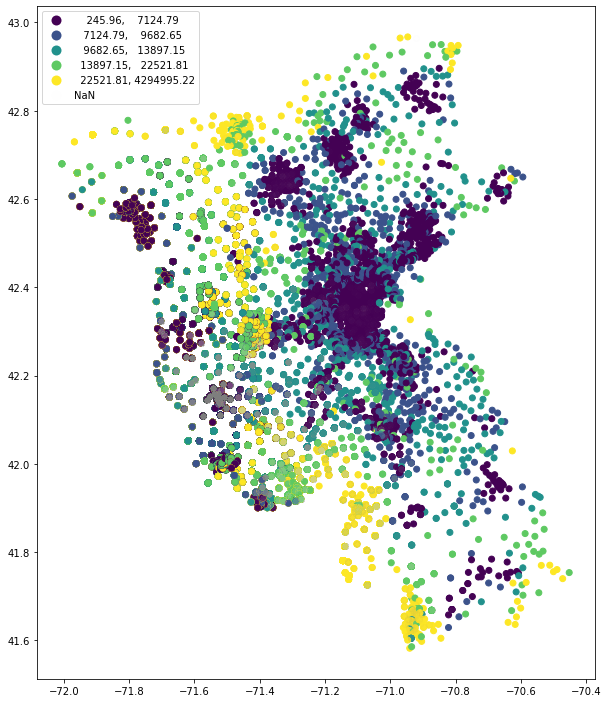

In [13]:
cbgs_withmedians_gdf.plot(column='md_'+category.replace(' ', '_'),
                          legend=True,
                          scheme='quantiles',
                          figsize=(10, 15),
                          missing_kwds={'color': 'lightgrey', 'alpha':0.01})

Note that there are many NaN values, corresponding to CBGs where there is no data. For now, we fill this with a placeholder value of 1km:

In [14]:
cbgs_withmedians_gdf = cbgs_withmedians_gdf.fillna(value=1000)

Extend network with POIs:

In [15]:
start = datetime.now()

exp_nodes, exp_edges, pois_with_access = connect_poi(pois_gdf, nodes, edges)

connection_complete=datetime.now()

print(' Connected POIs to walking network in:', connection_complete-start)

Building rtree...
Projecting POIs to the network...
Assigning nodes to POIs and updating...
Updating internal edges...
Adding external distance...
NOTE: duplication in node coordinates keys
Nodes count: 700643
Node coordinates key count: 698841
Missing 'from' nodes: 0
Missing 'to' nodes: 0
 Connected POIs to walking network in: 0:06:30.931603


Rebuild the graph on Pandana:

In [16]:
expanded_graph = pandana.Network(exp_nodes.geometry.x, exp_nodes.geometry.y,
                                 exp_edges['from'], exp_edges['to'],
                                 edge_weights=exp_edges[['length']])

Generating contraction hierarchies with 16 threads.
Setting CH node vector of size 700643
Setting CH edge vector of size 1832402
Range graph removed 1829010 edges of 3664804
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


Now we shall do the isochrons. For every cbg in the city, we first list all POIs within a radius of x km---this x is the median distance walked by residents of that CBG to visit that type of amenity.

In [17]:
#Get a dictionary of POIS for every category:
pois_gdf['x'] = pois_gdf.geometry.x
pois_gdf['y'] = pois_gdf.geometry.y
pois_with_access_gdf = pois_gdf.merge(pois_with_access[['access_node', 'access_distance']], left_index=True, right_index=True, how='left')
pois_with_access_dict = dict(tuple(pois_with_access_gdf.groupby('top_category')))
pois_with_access_dict[category]

,top_category,geometry,x,y,access_node,access_distance
safegraph_place_id,,,,,,
sg:07308c5ec06848d2ae04d247e26fd932,Restaurants and Other Eating Places,POINT (-71.05848 42.35380),-71.058478,42.353802,670200,9.407996
sg:20edbe6c07124d8386d16b9f85664c5d,Restaurants and Other Eating Places,POINT (-70.82439 42.12242),-70.824392,42.122416,670203,8.123756
sg:46d8502f0c4c4fd4b378f9c36b2f16c4,Restaurants and Other Eating Places,POINT (-70.66317 41.95891),-70.663165,41.958915,670204,5.921057
sg:5ee6809356db4740b7424fc0e6e506a0,Restaurants and Other Eating Places,POINT (-71.12447 42.32700),-71.124471,42.327005,670206,7.337853
sg:6d44f69bd7a647eaaacf5e7f15d218d4,Restaurants and Other Eating Places,POINT (-71.43248 42.52317),-71.432483,42.523167,670208,18.537710
...,...,...,...,...,...,...
sg:ad80466f47f64c2387ed64746e2f151c,Restaurants and Other Eating Places,POINT (-71.11865 42.70003),-71.118645,42.700030,700630,10.804421
sg:b2b4112c9248449c976f0a4744275f48,Restaurants and Other Eating Places,POINT (-71.02234 42.39994),-71.022340,42.399936,700632,8.549279
sg:be6d22a4b67c4953ae080b8562134c4d,Restaurants and Other Eating Places,POINT (-70.99359 42.41100),-70.993592,42.410997,700635,14.840036


We can set the POIs in our pandana network and get the cbgs node ids:

In [138]:
max_distance = 50000
max_pois = 500

expanded_graph.set_pois(category,
                        maxdist=max_distance,
                        maxitems=max_pois,
                        x_col=pois_with_access_dict[category]['x'],
                        y_col=pois_with_access_dict[category]['y'])

cbgs_withmedians_gdf['origin_node'] = expanded_graph.get_node_ids(x_col=cbgs_withmedians_gdf['geometry'].x,
                                                                  y_col=cbgs_withmedians_gdf['geometry'].y)

Now we can use the nearest POIs function:

In [139]:
start = datetime.now()

d = expanded_graph.nearest_pois(max_distance, category,
                                num_pois=max_pois,
                                imp_name='length',
                                include_poi_ids=True)

isochron_complete=datetime.now()
print(' Found the isochrons in:', isochron_complete-start)

 Found the isochrons in: 0:07:36.916168


In [140]:
d

,1,2,3,4,5,6,7,8,9,10,...,poi491,poi492,poi493,poi494,poi495,poi496,poi497,poi498,poi499,poi500
osmid,,,,,,,,,,,,,,,,,,,,,
0,4899.096191,5100.667969,5138.053223,5353.973145,7617.887207,8335.074219,8461.449219,8801.150391,8871.826172,9129.889648,...,sg:2f5d098637ea471bad0bce2ff533b8cc,sg:86cbd06c92b44c07ae6553b55e4a11c3,sg:efa7440a0a3041749b8ca6ffdd6915d6,sg:8ed09aba53a64247a1d12b7001e0c81b,sg:cd5f74374e37405c8cee8970c097e230,sg:a1911ad914c84b9c8e34e21f5b1a9726,sg:a5a503a174f84577a00c916784f59266,sg:7a1f0f04fb6546ca98dc284857172ba1,sg:f4d96c95818e4ed3b41b89b08a044e78,sg:0972708f8a3446f293c66dd3cb224299
1,4655.541016,4857.112793,4894.498047,5110.417969,7374.332031,8091.519043,8217.893555,8557.594727,8628.271484,8886.334961,...,sg:2f5d098637ea471bad0bce2ff533b8cc,sg:86cbd06c92b44c07ae6553b55e4a11c3,sg:efa7440a0a3041749b8ca6ffdd6915d6,sg:8ed09aba53a64247a1d12b7001e0c81b,sg:cd5f74374e37405c8cee8970c097e230,sg:a1911ad914c84b9c8e34e21f5b1a9726,sg:a5a503a174f84577a00c916784f59266,sg:7a1f0f04fb6546ca98dc284857172ba1,sg:f4d96c95818e4ed3b41b89b08a044e78,sg:0972708f8a3446f293c66dd3cb224299
2,4070.544922,4272.117188,4309.501953,4525.421875,6789.335938,7506.522949,7632.897949,7972.599121,8043.274902,8301.338867,...,sg:2f5d098637ea471bad0bce2ff533b8cc,sg:86cbd06c92b44c07ae6553b55e4a11c3,sg:efa7440a0a3041749b8ca6ffdd6915d6,sg:8ed09aba53a64247a1d12b7001e0c81b,sg:cd5f74374e37405c8cee8970c097e230,sg:a1911ad914c84b9c8e34e21f5b1a9726,sg:a5a503a174f84577a00c916784f59266,sg:7a1f0f04fb6546ca98dc284857172ba1,sg:f4d96c95818e4ed3b41b89b08a044e78,sg:0972708f8a3446f293c66dd3cb224299
3,4726.173828,4927.746094,4965.130859,5181.050781,7444.964844,8162.151855,8288.527344,8628.227539,8698.904297,8956.967773,...,sg:2f5d098637ea471bad0bce2ff533b8cc,sg:86cbd06c92b44c07ae6553b55e4a11c3,sg:efa7440a0a3041749b8ca6ffdd6915d6,sg:8ed09aba53a64247a1d12b7001e0c81b,sg:cd5f74374e37405c8cee8970c097e230,sg:a1911ad914c84b9c8e34e21f5b1a9726,sg:a5a503a174f84577a00c916784f59266,sg:7a1f0f04fb6546ca98dc284857172ba1,sg:f4d96c95818e4ed3b41b89b08a044e78,sg:0972708f8a3446f293c66dd3cb224299
4,5341.764160,5543.335938,5580.721191,5796.641113,8060.555176,8777.742188,8904.117188,8994.199219,8994.199219,9243.818359,...,sg:05e51adbbbbf4d08891e7794761a2bc6,sg:f6b5ec4acae1478ca644c94b9e644677,sg:f1402794c0c64dbd8df027cfdf9cab4b,sg:aa8411ebf30a4970aa8c089bc9613361,sg:0484ad5b49084a158279162199fbfba2,sg:6ed490796b1a4867b7e734e0f3d6deb1,sg:b0dc289eb9834c738aa5e6f1ff099dd2,sg:ae435634e16a42838b648c891ab1d4db,sg:e18af6b8aaeb4a8287e9d38922e902d0,sg:42ae4ea8e8f44a6e821bab18afcb0618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700638,76.968002,192.651001,225.345001,230.804993,265.549011,332.345001,338.681000,505.210999,702.007996,716.606018,...,sg:d89a4775fdaf4612b2e9e4a11fc9eb19,sg:ca381c706042486ba5c06fb33169d9f5,sg:a9c1962ae2814f489a48050daf37da04,sg:5e9f9a0a80b4464aa1e9c55f061f2b86,sg:4e6dc261f70944fab9a0a825a277cea1,sg:be9d747bbef2485ba3d63add683473de,sg:8fb04f3d573c4ffa8771613d98394749,sg:16e8c1a654b3446fbc80a1f8e4504d2e,sg:67f9708963d440e891dd1396382fe3ee,sg:e0650dbf0d7d49b29b593f529e35f8bd
700639,468.665985,546.263000,553.606018,644.010986,691.427979,749.465027,750.554016,754.161987,775.981995,775.981995,...,sg:acb83a49c8824fc69d5f2f66ac1c8841,sg:b08eee5684c44250999723d20bf0a6f5,sg:a6db2052dc4947129ecdc296a9b583fd,sg:7a4b5c2e291a4092a14d9608b751dcd4,sg:eacd0dfafcf24bb5b5cd2931ec13d4aa,sg:4897b1faf1e64558aca8359483b4a597,sg:7a7acd6d9c414ff0915c711b7fd872ce,sg:c6026b521e9b41f4aca538e4676341d4,sg:378711796ab544f3bdba68f3cdaaf3b3,sg:204340ffc6954af9b543b7bade4ed314
700640,35.148998,89.092003,94.946999,101.852997,228.529007,245.651993,389.225006,460.987000,611.638977,654.669983,...,sg:bfaf3f681a774e8a982db3ba1a542c2d,sg:c6c16df3c1f04698af913635dfde352c,sg:57073bce765c40889a9d54d70522ac33,sg:5c9c52bc16cb4b22998ec6d7fa893b14,sg:298bfe0b251044388177c0d7ac56140d,sg:d16c667bc493457288fd27becd69dbe0,sg:434547de556241fcb1d1877a8022d8f6,sg:a40fb3816be74e04ac8ee9d4c

With this dataframe we can construct our "isochron" dataframe:

In [141]:
isochron_df = cbgs_withmedians_gdf[['origin_node', 'md_'+category.replace(' ', '_')]].merge(d, left_on='origin_node', right_index=True, how='left')

Now we have functions to trim the isochrons depending on our threshold:

In [157]:
def trim_by_number(isochron_df, number):
    max_number = int(list(isochron_df.columns)[-1][3:])
    number = min(number, max_number)
    
    distances_df = isochron_df.iloc[:, 2:max_number+2]
    ids_df = isochron_df.iloc[:, max_number+2:]
    trimmed_df = isochron_df[[]]
    
    if number < max_number:
        dists_to_drop = [k for k in range(number+1, max_number)]
        ids_to_drop = ['poi{}'.format(k) for k in range(number+1, max_number)]
        
        trimmed_dists = distances_df.drop(labels=dists_to_drop, axis=1)
        trimmed_df['nearest_pois_distances'] = trimmed_dists.values.tolist()
        
        trimmed_ids = ids_df.drop(labels=ids_to_drop, axis=1)
        trimmed_df['nearest_pois_ids'] = trimmed_ids.values.tolist()
        
    else:
        trimmed_df['nearest_pois_distances'] = distances_df.values.tolist()
        trimmed_df['nearest_pois_ids'] = ids_df.values.tolist()
    
    return trimmed_df

def trim_by_dist(isochron_df, dist, max_dist=100000, max_pois=max_pois):
    max_number = int(list(isochron_df.columns)[-1][3:])
    dist = min(dist, max_dist)
    
    distances_lists_df = trim_by_number(isochron_df, max_pois)
    trimmed_df = isochron_df[[]]
    
    from bisect import bisect
    def get_trim_number(x, val=dist):
        return bisect(x, val)
    distances_lists_df['number'] = distances_lists_df['nearest_pois_distances'].apply(get_trim_number)
    
    def trim(l, end):
        return l[:end]
    
    trimmed_df['nearest_pois_distances'] = distances_lists_df.apply(lambda x: trim(x.nearest_pois_distances, x.number), axis=1)
    trimmed_df['nearest_pois_ids'] = distances_lists_df.apply(lambda x: trim(x.nearest_pois_ids, x.number), axis=1)
    
    return trimmed_df

def trim_by_median(isochron_df, max_median=100000, max_pois=max_pois):
    max_number = int(list(isochron_df.columns)[-1][3:])
    
    distances_lists_df = trim_by_number(isochron_df, max_pois)
    distances_lists_df['md'] = isochron_df.iloc[:,2]
    trimmed_df = isochron_df[[]]
    trimmed_df['cbg_mobility_median'] = isochron_df.iloc[:,2]
    
    from bisect import bisect
    def get_trim_number(x, val):
        return bisect(x, val)
    distances_lists_df['number'] = distances_lists_df.apply(lambda x: get_trim_number(x.nearest_pois_distances,
                                                                                      x.md), axis=1)
    
    def trim(l, end):
        return l[:end]
    
    trimmed_df['nearest_pois_distances'] = distances_lists_df.apply(lambda x: trim(x.nearest_pois_distances, x.number), axis=1)
    trimmed_df['nearest_pois_ids'] = distances_lists_df.apply(lambda x: trim(x.nearest_pois_ids, x.number), axis=1)
    
    return trimmed_df

def summarize_isochron(isochron_df, trim_method, trim_val=None, cat=None, fua_code='USA11'):
    """
    Summarizes the isochron dataframe according to our thresholding method
    
    :param isochron_df: dataframe with columns [origin_node, md_cat, 1, ... 100, poi1, ... poi100]
    :param trim_method: string, one of 'fixed_dist', 'fixed_number', 'median'
    """
    if cat is None:
        cat = [s for s in list(isochron_df.columns) if 'md' in str(s)][0][3:]
    
    if trim_method == 'fixed_dist':
        trimmed_df = trim_by_dist(isochron_df, trim_val)
    elif trim_method == 'fixed_number':
        trimmed_df = trim_by_number(isochron_df, trim_val)
    elif trim_method == 'median':
        trimmed_df = trim_by_median(isochron_df)
    else:
        print('NOT ABLE TO TRIM!')
        trimmed_df = isochron_df
    
    #Compute summary statistics:
    def median_nan(arr):
        try:
            return np.median(arr)
        except:
            return np.nan
    def min_nan(arr):
        try:
            return np.min(arr)
        except:
            return np.nan
    def max_nan(arr):
        try:
            return np.max(arr)
        except:
            return np.nan
    
    trimmed_df['median_dist'] = trimmed_df['nearest_pois_distances'].apply(median_nan)
    trimmed_df['min_dist'] = trimmed_df['nearest_pois_distances'].apply(min_nan)
    trimmed_df['max_dist'] = trimmed_df['nearest_pois_distances'].apply(max_nan)
    trimmed_df['count_dist'] = trimmed_df['nearest_pois_distances'].apply(len)
    
    #Save:
    filename = fua_code + '_' + cat + '_isochron_' + trim_method + '.csv'
    trimmed_df.to_csv('/work/accessibility/Isochrons/'+trim_method+'/'+filename)
    
    return trimmed_df

In [158]:
summarized = summarize_isochron(isochron_df, 'fixed_dist', trim_val=2000)

In [159]:
summarized.head()

,nearest_pois_distances,nearest_pois_ids,median_dist,min_dist,max_dist,count_dist
census_block_group,,,,,,
250010133001,[],[],NaN,NaN,NaN,0
250010133002,[],[],NaN,NaN,NaN,0
250010133003,[],[],NaN,NaN,NaN,0
250010134001,[],[],NaN,NaN,NaN,0
250010134002,[],[],NaN,NaN,NaN,0


Let's plot the number of restaurants within 2 km of a centroid:

Text(0.5, 1.0, 'Number of Restaurants within 2km of CBG centroid')

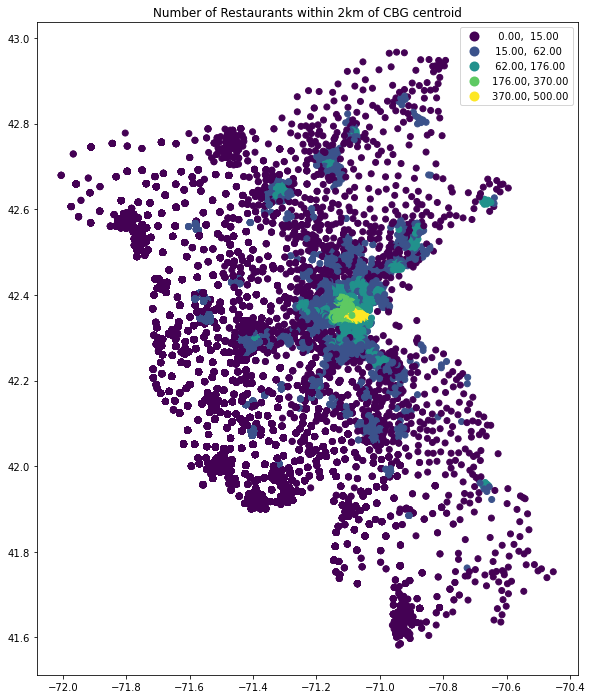

In [154]:
cbgs_to_plot = cbgs_gdf.merge(summarized, left_index=True, right_index=True)
ax = cbgs_to_plot.plot(column='count_dist',
                       legend=True,
                       scheme='natural_breaks',
                       cmap='viridis',
                       figsize=(10, 12))
ax.set_title('Number of Restaurants within 2km of CBG centroid')